In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import skorch

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torchvision

In [196]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super().__init__()
        self.l0 = nn.Linear(input_size, hidden_dim)
        self.l1 = nn.Linear(hidden_dim, hidden_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        l0 = self.l0(x)
        l0 = self.act(l0)
        l1 = self.l1(l0)
        l1 = self.act(l1)
        return l1

In [197]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.l0 = nn.Linear(hidden_dim, hidden_dim)
        self.l1 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        l0 = self.l0(x)
        l0 = self.act(l0)
        l1 = self.l1(l0)
        return l1

In [198]:
class Discretizer(nn.Module):
    def __init__(self, num_latents, hidden_dim):
        super().__init__()
        self.num_latents = num_latents
        self.hidden_dim = hidden_dim
        #self.e = nn.Parameter(torch.zeros((num_latents, hidden_dim)))
        self.e = nn.Parameter(torch.randn((num_latents, hidden_dim)))

    def distance(self, a, b):
        return ((a - b)**2).sum(dim=-1).sqrt()

    def forward(self, z_e):
        # compute min distance between z_e and self.e for each row in z_e,
        # return matrix with (_, e_{best match for each row})

        # to find the embedding row of self.e that matches best with the input
        # for each row in the input z_e, we first have to align both tensors.
        z_e_exp = z_e.repeat(1, self.e.size(0)).view(z_e.size(0) * self.e.size(0), -1)
        e_exp = self.e.repeat(z_e.size(0), 1)
        d = self.distance(z_e_exp, e_exp)

        d = d.view(z_e.size(0), self.e.size(0))

        _min_dists, idx = d.min(-1)
        #print(_min_dists)

        return self.e[idx]

In [199]:
class VQVAE(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_latents):
            super().__init__()
            self.enc = Encoder(input_dim, hidden_dim)
            self.dis = Discretizer(num_latents, hidden_dim)
            self.dec = Decoder(hidden_dim, input_dim)

        def forward(self, x):
            z_e = self.enc(x)
            e_k = self.dis(z_e)
            z_q = self.dec(e_k)
            return z_q, z_e, e_k

In [200]:
MNIST = torchvision.datasets.MNIST('../data', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [201]:
train_loader = lambda _ds, **kwargs: torch.utils.data.DataLoader(MNIST, **kwargs)

In [227]:
class Trainer(skorch.NeuralNet):
        def __init__(self, beta=0.25, criterion=nn.MSELoss, *args, **kwargs):
            self.beta = beta
            super().__init__(*args, criterion=criterion, **kwargs)
            
        def evaluation_step(self, *args, **kwargs):
            ret = super().evaluation_step(*args, **kwargs)
            return ret[0]

        def train_step(self, X, _, optimizer):
            optimizer.zero_grad()
            
            X = X.view(-1, 28 * 28)
            X = skorch.utils.to_var(X, use_cuda=self.use_cuda)
            y = skorch.utils.to_var(X, use_cuda=self.use_cuda)
            
            z_q, z_e, e_k = self.infer(X)
            
            def l2(x):
                return (x**2).sum().sqrt()
            
            def sg(x):
                return Variable(x.data)
            
            # Compute gradient for e_k -> z_q so 
            # we can pass the gradient wrt. e_k to 
            # the encoder gradient computation.
            e_k.retain_grad()
            L = self.criterion_(z_q, y)
            L.backward(retain_graph=True)
            e_k_grad = e_k.grad
            
            optimizer.zero_grad()
            
            L += l2(sg(z_e) - e_k)
            L += self.beta * l2(z_e - sg(e_k))
                                    
            # Compute the whole loss while passing the 
            # gradient wrt. e_k to the encoder.
            # We combine both gradients (third loss term 
            # and the passed gradient) to compute the
            # final gradient for the encoder.
            z_e.register_hook(lambda grad: grad + e_k_grad)
            #z_e.register_hook(lambda grad: e_k_grad)

            L.backward()

            optimizer.step()
            return L

In [228]:
ef = Trainer(
    module=VQVAE,
    module__input_dim=28 * 28,
    module__hidden_dim=128,
    module__num_latents=10,
    
    optimizer=torch.optim.Adam,
    optimizer__lr=0.002,

    iterator_train=train_loader,
    iterator_train__batch_size=64,
    
    train_split=None,
    
    callbacks=[skorch.callbacks.ProgressBar()],
).initialize()

In [229]:
%pdb on
if False:
    ef.load_params('vqvae.pt')
else:
    ef.fit(np.zeros(1), None)

Automatic pdb calling has been turned ON
Re-initializing module!


Widget Javascript not detected.  It may not be installed or enabled properly.


  epoch    train_loss      dur
-------  ------------  -------
      1   325512.6578  31.3744


Widget Javascript not detected.  It may not be installed or enabled properly.


      2  3093919.5543  36.3702


Widget Javascript not detected.  It may not be installed or enabled properly.


      3  8366164.2387  37.1147


Widget Javascript not detected.  It may not be installed or enabled properly.


In [205]:
ef.save_params('vqvae.pt')

In [206]:
ef.module_.dis.e.mean(dim=-1)

Variable containing:
-0.1061
 0.0476
-0.0732
 0.0163
 0.0537
 0.2818
 0.0216
 0.1769
 0.0354
 0.0396
[torch.FloatTensor of size 10]

In [207]:
ef.module_.dis.e.mean(dim=-1)

Variable containing:
-0.1061
 0.0476
-0.0732
 0.0163
 0.0537
 0.2818
 0.0216
 0.1769
 0.0354
 0.0396
[torch.FloatTensor of size 10]

### Evaluation

In [208]:
num_samples = 10
grid_side = np.ceil(np.sqrt(num_samples))
X_eval = np.array([x.view(28 * 28) for _, (x,y) in zip(range(num_samples), iter(MNIST))])
X_eval_hat = ef.predict_proba(X_eval)

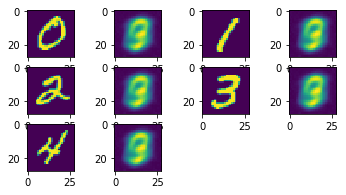

In [209]:
for i in range(1, num_samples, 2):
    plt.subplot(grid_side, grid_side, i)
    plt.imshow(X_eval[i].numpy().reshape(28, 28))
    plt.subplot(grid_side, grid_side, i+1)
    plt.imshow(X_eval_hat[i].reshape(28, 28))

In [210]:
z_q, z_e, e_k = ef.infer(torch.stack(X_eval, dim=0))

In [211]:
z_e

Variable containing:
 0.0000  0.0000  0.0000  ...   0.3947  0.4225  0.4647
 0.0000  0.0000  0.0000  ...   0.3931  0.4217  0.4630
 0.0000  0.0000  0.0000  ...   0.3922  0.4192  0.4626
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   0.3949  0.4233  0.4643
 0.0000  0.0000  0.0000  ...   0.3929  0.4210  0.4623
 0.0000  0.0000  0.0000  ...   0.3945  0.4234  0.4643
[torch.FloatTensor of size 10x128]

In [212]:
e_k

Variable containing:
 1.9661e-04  2.8152e-04 -7.9465e-05  ...   3.9167e-01  4.1696e-01  4.6273e-01
 1.9661e-04  2.8152e-04 -7.9465e-05  ...   3.9167e-01  4.1696e-01  4.6273e-01
 1.9661e-04  2.8152e-04 -7.9465e-05  ...   3.9167e-01  4.1696e-01  4.6273e-01
                ...                   ⋱                   ...                
 1.9661e-04  2.8152e-04 -7.9465e-05  ...   3.9167e-01  4.1696e-01  4.6273e-01
 1.9661e-04  2.8152e-04 -7.9465e-05  ...   3.9167e-01  4.1696e-01  4.6273e-01
 1.9661e-04  2.8152e-04 -7.9465e-05  ...   3.9167e-01  4.1696e-01  4.6273e-01
[torch.FloatTensor of size 10x128]

### Distance between latent vectors

In [223]:
D = np.array([[ef.module_.dis.distance(a,b).data[0] for a in ef.module_.dis.e] 
              for b in ef.module_.dis.e])

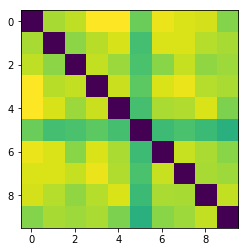

In [224]:
plt.imshow(D)